<h1 align="center"> Credit Fraud Detector </h1>

<h3> I. About this Project </h3>
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

<h3> II. About the Data </h3>
The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

<h3> III. Final Goal </h3>
<ul>
<li> Understand the little distribution of the "little" data that was provided to us. </li>
<li> Create a 50/50 sub-dataframe ratio of "Fraud" and "Non-Fraud" transactions. (NearMiss Algorithm) </li>
<li> Determine the Classifiers we are going to use and decide which one has a higher accuracy. </li>
<li>Create a Neural Network and compare the accuracy to our best classifier. </li>
<li>Understand common mistaked made with imbalanced datasets. </li>
</ul>

<h3> IV. Caveats </h3>

<ul>
<li> Never test on the oversampled or undersampled dataset.</li>
<li>If we want to implement cross validation, remember to oversample or undersample your training data <b>during</b> cross-validation, not before! </li>
<li> Don't use <b>accuracy score </b> as a metric with imbalanced datasets (will be usually high and misleading), instead use <b>f1-score, precision/recall score or confusion matrix </b></li>
</ul>

### 1. Import Data

In [1]:
# Import Libraries

import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import warnings
import pickle

warnings.filterwarnings("ignore")

In [2]:
# Import Data 
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Dataset Shape & NA values
df.isnull().sum().max() # no null values
df.columns = df.columns.str.lower()
df.columns

Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'class'],
      dtype='object')

### 2. Sanity Check

In [4]:
# check outcome data
df['class'].value_counts()
print('No Fraud: ', round(df['class'].value_counts()[0]/len(df['class'])*100, 2), '%')
print('Fraud: ', round(df['class'].value_counts()[1]/len(df['class'])*100, 2), '%')

No Fraud:  99.83 %
Fraud:  0.17 %


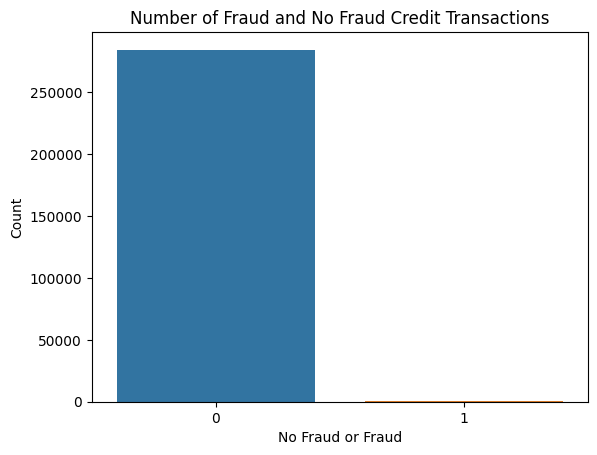

In [5]:
# Create the bar plot
sns.countplot(x=df['class'])

# Add labels and title
plt.xlabel("No Fraud or Fraud")
plt.ylabel("Count")
plt.title("Number of Fraud and No Fraud Credit Transactions")

# Show the plot
plt.show()

In [6]:
# Amount and Time Distribution
df[['amount', 'time']].describe()

,amount,time
count,284807.000000,284807.000000
mean,88.349619,94813.859575
std,250.120109,47488.145955
min,0.000000,0.000000
25%,5.600000,54201.500000
50%,22.000000,84692.000000
75%,77.165000,139320.500000
max,25691.160000,172792.000000


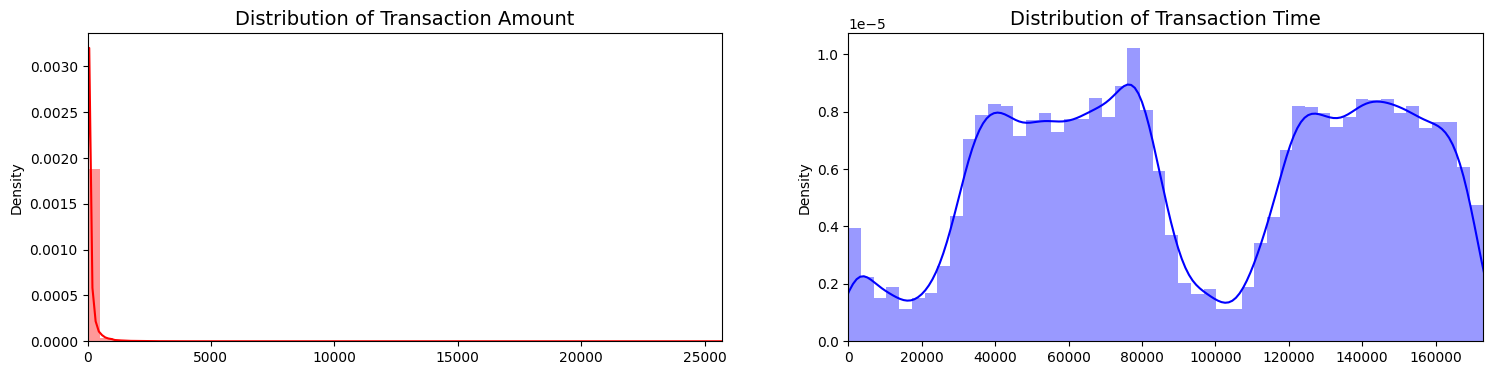

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['amount'].values
time_val = df['time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

### 3. Scaling 

In [10]:
# scaling data 
from sklearn.preprocessing import RobustScaler 
rob_scaler = RobustScaler()

# scale time and amount
df['amount_sc'] = rob_scaler.fit_transform(df[['amount']])
df['time_sc'] = rob_scaler.fit_transform(df[['time']])

# delete original columns
df.drop(['time', 'amount'], axis = 1, inplace = True)

In [11]:
df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v22,v23,v24,v25,v26,v27,v28,class,amount_sc,time_sc
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [28]:
df[['amount_sc', 'time_sc']].describe()

,amount_sc,time_sc
count,284807.000000,284807.000000
mean,0.927124,0.118914
std,3.495006,0.557903
min,-0.307413,-0.994983
25%,-0.229162,-0.358210
50%,0.000000,0.000000
75%,0.770838,0.641790
max,358.683155,1.035022


### 4. Save processed data to pickle file

In [16]:
data = df
file_path = 'processed_data.pkl'

with open(file_path, 'wb') as file:
    # Write the data to the file using pickle.dump()
    pickle.dump(data, file)